In [ ]:
using ProgressBars;

using LinearAlgebra, Plots, FFTW;
function plus(x)
    return max(x, 0)
end

function minus(x)
    return max(-x, 0)
end

function create_D_vecs(u_vec, t_n, h, C_H) # returns Dplusminus and Dminusplus vectors
    Dplus = [diff(u_vec); 0] ./ h
    Dminus = [0; diff(u_vec)] ./ h
    Dplus[end] = (u_vec[1] - u_vec[end]) / h
    Dminus[1]= (u_vec[1] - u_vec[end]) / h 
    Dplusminus = minus.(Dplus)
    Dminusplus = plus.(Dminus)
    Dplusplus = plus.(Dplus)
    Dminusminus = minus.(Dminus)
    return (Dplusminus, Dminusplus, Dplusplus, Dminusminus)
end

function g_func(u_vec, t_n, h, C_H)
    (Dplusminus, Dminusplus, temp, temp) = create_D_vecs(u_vec, t_n, h, C_H)
    return C_H .* (Dplusminus .^2 + Dminusplus .^2)
end

function create_Dg_mat(v, t_n, N_h, h, C_H) # verified is correct
    (Dplusminus, Dminusplus, temp, temp) = create_D_vecs(v, t_n, h, C_H);
    Dg_mat = zeros(N_h, N_h)
    tridiag = Tridiagonal(-Dminusplus[2:end], Dplusminus + Dminusplus, -Dplusminus[1:end-1])
    Dg_mat[1, N_h] = -Dminusplus[1]
    Dg_mat[N_h, 1] = -Dplusminus[end]
    Dg_mat += tridiag
    Dg_mat *= 2/h
    return  C_H .* Dg_mat
end
using SpecialFunctions: gamma, loggamma, zeta
function TS(m, α, N_h, R)
    if m==0
        return 0
    end
    K_α = 0.0
    for ν in -R:1:R
        K_α += exp( loggamma( abs(m - N_h*ν) - α/2 )  - loggamma( ( abs(m - N_h*ν) + 1 + α/2) )  )
    end
    return K_α
end
    

#function create_DPL_matrix(N_h, α, h, R)
#    DPL_mat = Matrix{Float64}(undef, N_h, N_h)
#    zeta_term= zeta(1+α)
#    for i in 1:N_h
#        for j in 1:N_h
#            DPL_mat[i,j] = TS(abs(i-j), α, N_h, R)
#        end
#    end
#    for γ in 1:N_h
#        DPL_mat[γ, γ] = -(sum([TS(β-γ, α, N_h, R) for β in 1:N_h]) + 2*zeta_term - 
#        sum([1/k^(1+α) for k in 1:((R+1)*N_h - γ) ]) - sum([1/k^(1+α) for k in 1:(R*N_h + γ - 1) ]))
#    end
#    c_α = 2^α * gamma((1+α)/2) / (√π * abs(gamma(-α/2)) )
#    return -c_α / (h^α) * DPL_mat
#end



function create_DPL_matrix(N_h, α, h, R) # new method, spectral method. Verified agains old method, and gives zero row sums.
    k = collect(0:N_h-1)
    λ = (2 .- 2 .* cos.(2π .* k ./ N_h)).^(α/2) ./ h^α  # λ_0 = 0
    # First column of the circulant is the inverse FFT of eigenvalues
    c = real(ifft(λ))                       # first column
    D = zeros(Float64, N_h, N_h)
    for j in 1:N_h
        D[:, j] = circshift(c, j-1)
    end
    return D
end


function tranport_matrix(U, t_n, N_h, h, C_H) # verified!
    (DPM, DMP, DPP, DMM) = create_D_vecs(U, t_n, h, C_H);
    TU_mat = zeros(N_h, N_h)
    tridiag = Tridiagonal(DMM[2:end], -DPM - DMP, DPP[1:end-1])
    TU_mat[1, N_h] = DMM[1]
    TU_mat[N_h, 1] = DPP[end]
    # tridiag = Tridiagonal(DMM[1:end-1], -(DMP + DPM), DPP[2:end])
    # TU_mat[1, N_h] = DMM[end]
    # TU_mat[N_h, 1] = DPP[1]
    TU_mat += tridiag
    TU_mat *= 2/h # not by h
    return C_H .* TU_mat
end


function mathcalF(U_np1, U_n, M_n, DPL_matrix, x_vec, n, N_h, Δt, h, ν, α, R,δ, C_H)
    return U_np1 - U_n + Δt*( ν*DPL_matrix*U_np1 + g_func(U_np1, n*Δt, h, C_H) - F_h(M_n, x_vec, 2-n*Δt,δ))
end

function J_F(x, DPL_matrix, t_n, N_h, Δt, h, ν, α, R, C_H) # verified is correct
    Dg_mat = create_Dg_mat(x, t_n, N_h, h, C_H)
    return 1.0I(N_h) + Δt*(ν*DPL_matrix + Dg_mat)
end

function HJB_step(U_n, M_n, DPL_matrix, num_it_HJB, x_vec, n, N_h, Δt, h, ν, α, R,δ,C_H)
    U_np1 = U_n 
    for _ in num_it_HJB
        jacobi = J_F(U_np1, DPL_matrix, n*Δt, N_h, Δt, h, ν, α, R, C_H)
        F_vec = mathcalF(U_np1, U_n, M_n, DPL_matrix, x_vec, n, N_h, Δt, h, ν, α, R,δ,C_H)
        δ = jacobi \ F_vec
        U_np1 = U_np1 - δ
    end
    return U_np1
end

function HJB_solve(M_mat, num_it_HJB, x_vec, N_h, Δt, N_T, h, ν, α, R, δ, C_H)
    U_mat = Array{Float64}(undef, N_h, N_T)
    U_mat[:,1] = G_h(M_mat[:,1])
    DPL_matrix = create_DPL_matrix(N_h, α, h, R)
    for n in 1:(N_T-1)
        U_mat[:, n+1]= HJB_step(U_mat[:, n], M_mat[:, n], DPL_matrix, num_it_HJB, x_vec, n, N_h, Δt, h, ν, α, R,δ,C_H)
    end
    return U_mat
end

function FPK_step(U_np1, M_np1, n, DPL_mat, N_h, Δt, h, ν, α, R, C_H) # not exactly verified, but DPL and TU is verified.
    TU = tranport_matrix(U_np1, n*Δt, N_h, h, C_H)
    total_mat = 1.0I(N_h) + Δt *(ν*DPL_mat - TU)
    M_n = total_mat \ M_np1
    return M_n
end
function FPK_solve(U_mat, M_T, N_h, Δt, N_T, h, ν, α, R, C_H)
    M_mat = Array{Float64}(undef, N_h, N_T)
    M_mat[:,end] = M_T
    DPL_mat = create_DPL_matrix(N_h, α, h, R)
    for j in 1:(N_T-1)
        M_mat[:, N_T-j]= FPK_step(U_mat[:, N_T-j+1], M_mat[:, N_T-j+1], N_T-j+1, DPL_mat, N_h, Δt, h, ν, α, R, C_H)
    end
    return M_mat
end

function MFG_solve(M_T, cv)
    (α, h, N_h, Δt, N_T, ν, num_it_MFG, num_it_HJB, x_vec, R, δ, C_H) = cv;
    M_mat = Array{Float64}(undef, N_h, N_T); M_mat .= M_T;
    U_mat = Array{Float64}(undef, N_h, N_T);
    for _ in ProgressBar(1:num_it_MFG)
        U_mat = HJB_solve(M_mat, num_it_HJB, x_vec, N_h, Δt, N_T, h, ν, α, R, δ, C_H)
        M_mat = FPK_solve(U_mat, M_T, N_h, Δt, N_T, h, ν, α, R, C_H)
    end
    return (U_mat, M_mat)
end

using QuadGK;

function ϕ_δ(x, δ)
    1/(δ* sqrt(2*π)) * exp(-x^2 / (2*δ^2))
end

# function conv_term(m_vec, x_vec, δ)
#     h = x_vec[2] - x_vec[1]
#     N_h = length(m_vec)
#     conv_vec = Vector{Float64}(undef, N_h)
#     for j in 1:N_h
#         conv_vec[j] = h*sum( [ m_vec[i] * ϕ_δ(x_vec[j] - x_vec[i],δ) for i in 1:N_h]) # * h
#     end
#     return conv_vec
# end

function conv_term(m_vec, x_vec, δ)
    N_h = length(m_vec)
    h = x_vec[2] - x_vec[1]
    conv_vec = Vector{Float64}(undef, N_h)

    # Base offsets from reference node and minimum-image wrap
    # Δs = x_vec .- x_vec[1]
    # Δs .-= round.(Δs)  # map to (-0.5, 0.5]
    Δs = (x_vec .- x_vec[1]) .- round.(x_vec .- x_vec[1])  # (-0.5, 0.5]

    # Periodic kernel weights and discrete normalization
    weights = ϕ_δ.(Δs, δ)
    Z = h * sum(weights)
    weights ./= Z

    # Circular convolution with circulant weights (O(N^2), robust and simple)
    for j in 1:N_h
        s = 0.0
        for i in 1:N_h
            idx = mod(j - i, N_h) + 1  # 1-based index
            s += weights[idx] * m_vec[i]
        end
        conv_vec[j] = h * s
    end
    return conv_vec
end

# f_func = (x, t) -> cos(2*pi*(x-t^2))^2
f_func = (x, t) -> 5*(x − 0.5(1 − sin(2*π*t)))^2

function F_h(M, x_vec, t_n,δ)
    ϕm = conv_term(M, x_vec,δ)
    fⁿ = [f_func(x_i, t_n) for x_i in x_vec]
    return ϕm + fⁿ
end

### INITIAL AND TERMINAL CONDITIONS

function G_h(M)
    return zeros(length(M))
end

# m_T_func_unnorm = (x) -> exp(-50*(x-0.5)^2)
m_T_func_unnorm = (x) -> exp(-(x-0.5)^2/0.1^2)
oneOverC, error = quadgk(m_T_func_unnorm, 0, 1);

function m_T_func(x)
    return 1/oneOverC * m_T_func_unnorm(x) 
end

m_T_func (generic function with 1 method)

In [ ]:
#RUN SIMULATION

using DelimitedFiles;
println("START")
### Solution for different h

##########
run = "MFG_convergence_rate_runs/run8" #Folder to save runs too. NB: Change run number so old runs aren't overwritten.
##########

####Choose grid sizes:
h_reference = 1/2^9
h_list = [1/2^5, 1/2^6, 1/2^7,1/2^8, h_reference]
###################################+

M_list = Array{Float64}[]
U_list = Array{Float64}[]

println("hlist: ", h_list)
println("h_reference: ", h_reference)
println("M_list: ", M_list)
println("U_list", U_list)

for h in h_list
    println("")
    println("start for loop, h=", h)
    ####### NB Might take some time to run

    ####Select the right parameters: 
    #NB: Add the parameters for each new run to the MFG_convergence_runs_parameters.ipynb file so we know what 
    #parameters were used for each run.
    α = 1.0
    x_vec = -1:h:(2-h);
    N_h =length(x_vec);
    Δt = 0.001
    t_vec = 0:Δt:(1-Δt)
    N_T =length(t_vec)
    ν=0.09^2
    num_it_MFG=50
    num_it_HJB=20
    δ = 0.4
    R=30
    C_H = 0.5
    cv = (α, h, N_h, Δt, N_T, ν, num_it_MFG, num_it_HJB, x_vec, R, δ, C_H); # create a constant-vector, to avoid clutter for all constants we need.
    println("C_H: ", C_H)
    #terminal condition
    M_T =  m_T_func.(x_vec);
    ################################

    println("Running MFG_solve with h=", h)
    (U_mat, M_mat) = MFG_solve(M_T, cv);
    M_mat = reverse(M_mat, dims=2);
    U_mat = reverse(U_mat, dims=2);
    ############

    println("Done running MFG_sovle with h=", h)
    #println("M_mat: ")
    #println(M_mat)
    
    println("size(M_mat): ", size(M_mat))
    println("size(U_mat): ", size(U_mat))

    push!(M_list, M_mat)
    push!(U_list, U_mat)
    println("!!!!!!!!!!!!!!")
    writedlm(run*"_U_mat_convergence_h_"*string(h)*"deltat_"*string(Δt)*".csv", U_mat, ",")
    writedlm(run*"_M_mat_convergence_h_"*string(h)*"deltat_"*string(Δt)*".csv", M_mat, ",")
end

println("DONE")
println("size(M_list): ", size(M_list))
println("size(U_list): ", size(U_list))

START
hlist: [0.03125, 0.015625, 0.0078125, 0.00390625, 0.001953125]
h_reference: 0.001953125
M_list: Array{Float64}[]
U_listArray{Float64}[]

start for loop, h=0.03125
C_H: 0.5
Running MFG_solve with h=0.03125


0.0%┣                                               ┫ 0/50 [00:00<00:00, -0s/it]
2.0%┣▉                                          ┫ 1/50 [00:00<Inf:Inf, InfGs/it]
4.0%┣██                                              ┫ 2/50 [00:01<00:43, 1it/s]
6.0%┣██▉                                             ┫ 3/50 [00:01<00:31, 1it/s]
8.0%┣███▉                                            ┫ 4/50 [00:02<00:27, 2it/s]
10.0%┣████▊                                          ┫ 5/50 [00:02<00:25, 2it/s]
12.0%┣█████▋                                         ┫ 6/50 [00:03<00:23, 2it/s]
14.0%┣██████▋                                        ┫ 7/50 [00:03<00:22, 2it/s]
16.0%┣███████▌                                       ┫ 8/50 [00:04<00:21, 2it/s]
18.0%┣████████▌                                      ┫ 9/50 [00:04<00:20, 2it/s]
20.0%┣█████████▏                                    ┫ 10/50 [00:04<00:20, 2it/s]
22.0%┣██████████▏                                   ┫ 11/50 [00:05<00:19, 2it/s]
24.0%┣███████████           

Done running MFG_sovle with h=0.03125
size(M_mat): (96, 1000)
size(U_mat): (96, 1000)
!!!!!!!!!!!!!!


100.0%┣█████████████████████████████████████████████┫ 50/50 [00:22<00:00, 2it/s]
100.0%┣█████████████████████████████████████████████┫ 50/50 [00:22<00:00, 2it/s]



start for loop, h=0.015625
C_H: 0.5
Running MFG_solve with h=0.015625


0.0%┣                                               ┫ 0/50 [00:00<00:00, -0s/it]
2.0%┣▉                                          ┫ 1/50 [00:08<Inf:Inf, InfGs/it]
4.0%┣█▉                                             ┫ 2/50 [00:15<12:22, 15s/it]
6.0%┣██▉                                            ┫ 3/50 [00:23<09:04, 12s/it]
8.0%┣███▊                                           ┫ 4/50 [00:31<07:52, 10s/it]
10.0%┣████▋                                         ┫ 5/50 [00:38<07:11, 10s/it]
12.0%┣█████▋                                         ┫ 6/50 [00:46<06:44, 9s/it]
14.0%┣██████▋                                        ┫ 7/50 [00:53<06:22, 9s/it]
16.0%┣███████▌                                       ┫ 8/50 [01:01<06:06, 9s/it]
18.0%┣████████▌                                      ┫ 9/50 [01:09<05:52, 9s/it]
20.0%┣█████████▏                                    ┫ 10/50 [01:16<05:40, 8s/it]
22.0%┣██████████▏                                   ┫ 11/50 [01:24<05:28, 8s/it]
24.0%┣███████████           

Done running MFG_sovle with h=0.015625
size(M_mat): (192, 1000)
size(U_mat): (192, 1000)
!!!!!!!!!!!!!!

start for loop, h=0.0078125
C_H: 0.5
Running MFG_solve with h=0.0078125


100.0%┣█████████████████████████████████████████████┫ 50/50 [06:55<00:00, 8s/it]
100.0%┣█████████████████████████████████████████████┫ 50/50 [06:55<00:00, 8s/it]
0.0%┣                                               ┫ 0/50 [00:00<00:00, -0s/it]
2.0%┣▉                                          ┫ 1/50 [00:18<Inf:Inf, InfGs/it]
4.0%┣█▉                                             ┫ 2/50 [00:38<30:03, 38s/it]
6.0%┣██▉                                            ┫ 3/50 [00:54<21:18, 27s/it]
8.0%┣███▊                                           ┫ 4/50 [01:11<18:06, 24s/it]
10.0%┣████▋                                         ┫ 5/50 [01:27<16:24, 22s/it]
12.0%┣█████▌                                        ┫ 6/50 [01:44<15:14, 21s/it]
14.0%┣██████▍                                       ┫ 7/50 [02:01<14:24, 20s/it]
16.0%┣███████▍                                      ┫ 8/50 [02:17<13:43, 20s/it]
18.0%┣████████▎                                     ┫ 9/50 [02:34<13:07, 19s/it]
20.0%┣█████████             

Done running MFG_sovle with h=0.0078125
size(M_mat): (384, 1000)
size(U_mat): (384, 1000)
!!!!!!!!!!!!!!

100.0%┣████████████████████████████████████████████┫ 50/50 [16:14<00:00, 20s/it]
100.0%┣████████████████████████████████████████████┫ 50/50 [16:14<00:00, 20s/it]




start for loop, h=0.00390625
C_H: 0.5
Running MFG_solve with h=0.00390625


0.0%┣                                               ┫ 0/50 [00:00<00:00, -0s/it]


In [7]:
#READ FROM FILE

#Choose the same grid sizes h as were used when generating the data:
h_reference_used = 1/2^9
h_list_used = [1/2^5, 1/2^6, 1/2^7]#, 1/2^8, h_reference_used]

run="MFG_convergence_rate_runs/run8" #folder containing runs, and run number
alpha_used = 1.0
t_step_used = 0.001
end_T_used = 1



using DelimitedFiles;

function read_run_results(h_list_used, t_step_used, run_number)
    U_list = []
    M_list = []
    run="MFG_convergence_rate_runs/run"*string(run_number)
    for h_used in h_list_used
        push!(U_list, readdlm(run*"_U_mat_convergence_h_"*string(h_used)*"deltat_"*string(t_step_used)*".csv", ','))
        push!(M_list, readdlm(run*"_M_mat_convergence_h_"*string(h_used)*"deltat_"*string(t_step_used)*".csv", ','))
    end
    return U_list, M_list
end

read_run_results (generic function with 1 method)

In [ ]:
U_list, M_list = read_run_results(h_list_used, t_step_used, 8)

print(sum(M_list[3][:,100]*h_list_used[5]))

ArgumentError: ArgumentError: Cannot open 'MFG_convergence_rate_runs/run7_U_mat_convergence_h_0.03125deltat_0.001.csv': not a file

In [5]:
#PLOT RESULTS

# plotusing Plots, LaTeXStrings;
using DelimitedFiles;
using Plots, LaTeXStrings;
using Printf

function plot_results(h_list_used, t_step_used, end_T_used, alpha_used, run_number)
    U_list, M_list = read_run_results(h_list_used, t_step_used, run_number)
    println("HI") 
    println(h_list_used)
    println("!!")
    println("size(U_list): ", size(U_list))
    flush(stdout)
    for (i,h) in enumerate(h_list_used)
        println("----")
        println("i: ", i)
        x_vec = -1:h:(2-h);
        N_h =length(x_vec);
        
        #Select the same parameters as those used when generating the data:
        α = alpha_used
        Δt = t_step_used
        t_vec = 0:Δt:(end_T_used-Δt)
        N_T =length(t_vec)
        ν=0.09^2
        num_it_MFG=50
        num_it_HJB=20
        δ = 0.4
        R=30
        C_H = 0.5
        ####################################

        plot_U_mat = U_list[i];
        plot_M_mat = M_list[i];

        zticks1 = 5:5:20
        p1 = plot(t_vec, x_vec, plot_M_mat, ylabel=L"x", xlabel=L"t",  st=:surface, labelfontsize=15, zlim=(0,50),
        color=cgrad(:cool, rev=false), size=(500, 500), xlim=(0,t_vec[end]), ylim=(0.1,0.9), legend=false, camera=(90- 20, 20), xflip=true, zticks=zticks1, title=L"m(x,t)")
        zticks2 = 0.5:0.5:4
        p2 = plot(t_vec, x_vec, plot_U_mat, xlabel=L"t", ylabel=L"x",   st=:surface, labelfontsize=15,
        color=:cividis, size=(500, 500), xlim=(0,t_vec[end]), zlim=(0, 4), legend=false, camera=(90- 20, 40), xflip=true, zticks=zticks2, title=L"u(x,t)",  ylim=(0, 1))

        # Save plots as PDF with h in the filename
        #savefig(p1, joinpath("figures",run*"_plot_M_h__$(h).pdf"))
        #savefig(p2, joinpath("figures",run*"_plot_U_h__$(h).pdf"))

        p = plot(p1, p2, layout=2, size=(600, 300), title="h="*string(h), titlefontsize=10)
        println("Display:") 
        display(p)
        # println("i: ", i)
        # if i==1
        #     break
        # end
        println("!!!!!!!!!")
    end
end

plot_results (generic function with 1 method)

HI
[0.03125, 0.015625, 0.0078125]
!!
size(U_list): (3,)
----
i: 1
Display:
!!!!!!!!!
----
i: 2
Display:
!!!!!!!!!
----
i: 3
Display:
!!!!!!!!!


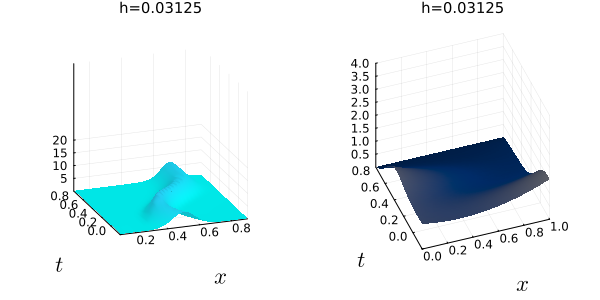

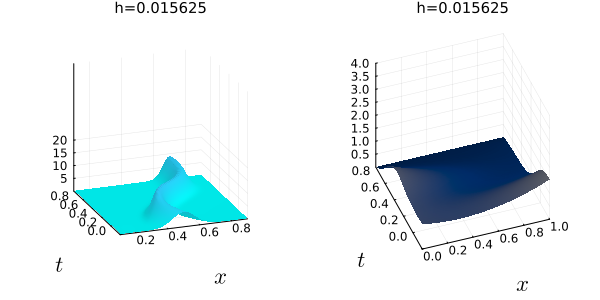

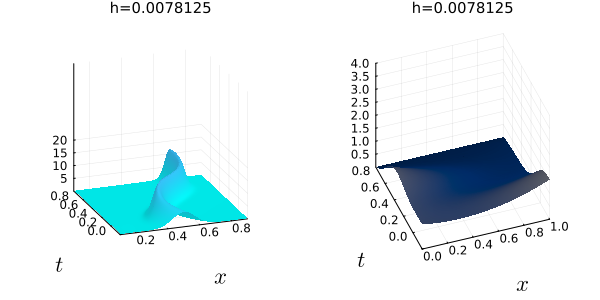

In [8]:
plot_results(h_list_used, 0.001, 1.0, 1.0, 8)

HI
[0.03125, 0.015625, 0.0078125, 0.00390625, 0.001953125]
!!
size(U_list): (5,)
----
i: 1
Display:
!!!!!!!!!
----
i: 2
Display:
!!!!!!!!!
----
i: 3
Display:
!!!!!!!!!
----
i: 4
Display:
!!!!!!!!!
----
i: 5
Display:
!!!!!!!!!


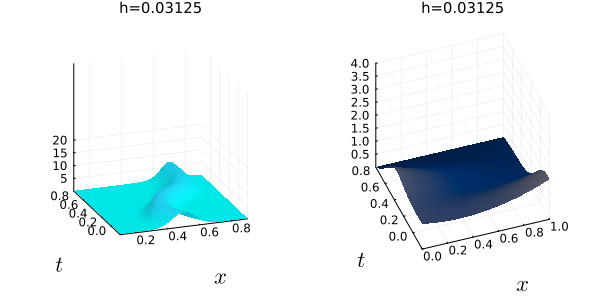

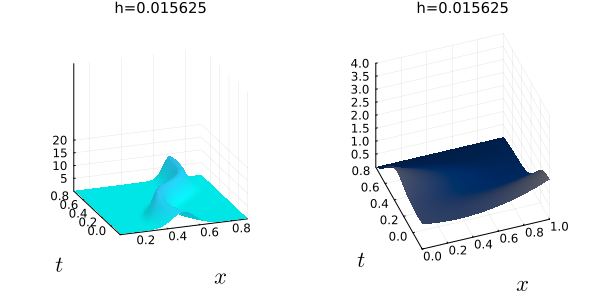

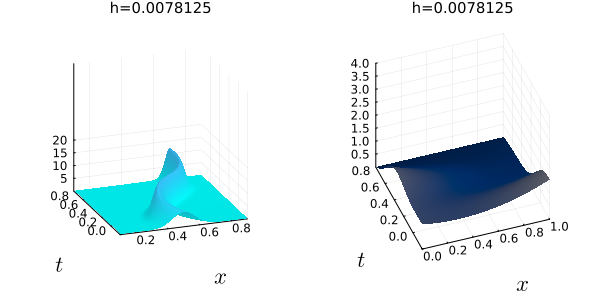

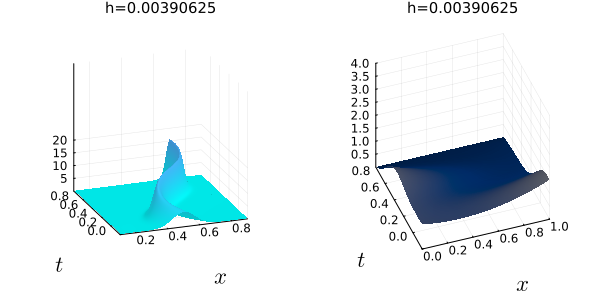

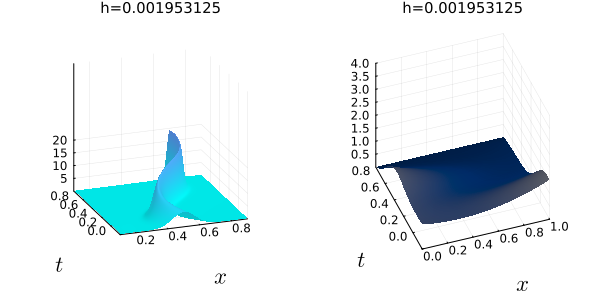

In [25]:
plot_results(h_list_used, 0.0005, 1.0, 1.0, 6)

In [9]:

#PLOT RESULTS AT FINAL TIME

function plot_final_time_results(h_list_used, t_step_used, end_T_used, alpha_used, run_number)
    U_list, M_list = read_run_results(h_list_used, t_step_used, run_number)

    println("FINAL TIME PLOTS")
    flush(stdout)

    for (i,h) in enumerate(h_list_used)
        println("----")
        println("i: ", i)
        x_vec = -1:h:(2-h);
        N_h =length(x_vec);
        #Select the same parameters as those used when generating the data:
        α = alpha_used
        Δt = t_step_used
        t_vec = 0:Δt:(end_T_used-Δt)
        N_T =length(t_vec)
        ν=0.09^2
        num_it_MFG=50
        num_it_HJB=20
        δ = 0.4
        R=30
        C_H = 0.5
        ###################################
        time_index = div(length(t_vec),1)
        println("time_index: ", time_index)

        plot_U_mat_final = U_list[i][:,1];
        plot_M_mat_final = M_list[i][:,time_index];

        p1 = plot(x_vec, plot_M_mat_final, xlabel=L"x", ylabel=L"y", labelfontsize=15,title="h="*string(h)*", t="*string(t_vec[time_index]),
        color=cgrad(:cool, rev=false), size=(500, 500), legend=false) #, xlim=(0,1) )
        zticks2 = 0.5:0.5:4
        p2 = plot(x_vec, plot_U_mat_final, xlabel=L"x", ylabel=L"y", labelfontsize=15,title="h="*string(h)*", t="*string(t_vec[1]),
        color=:cividis, size=(500, 500), legend=false) #,xlim=(0, 1),)

        p = plot(p1, p2, layout=2, size=(400, 200), titlefontsize=10)
        println("Display:")
        display(p)
        # println("i: ", i)
        # if i==1
        #     break
        # end
        println("!!!!!!!!!")
    end
end

plot_final_time_results (generic function with 1 method)

FINAL TIME PLOTS
----
i: 1
time_index: 1000
Display:
!!!!!!!!!
----
i: 2
time_index: 1000
Display:
!!!!!!!!!
----
i: 3
time_index: 1000
Display:
!!!!!!!!!


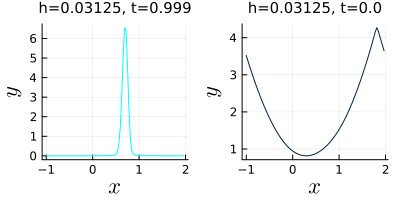

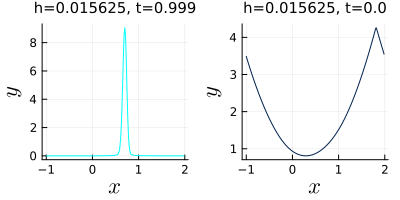

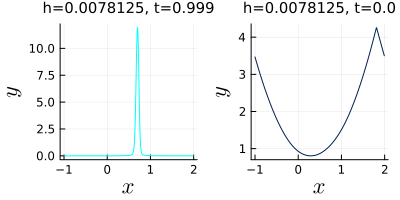

In [10]:
plot_final_time_results(h_list_used, 0.001, 1.0, 1.0, 8)

FINAL TIME PLOTS
----
i: 1
time_index: 100
Display:
!!!!!!!!!
----
i: 2
time_index: 100
Display:
!!!!!!!!!
----
i: 3
time_index: 100
Display:
!!!!!!!!!
----
i: 4
time_index: 100
Display:
!!!!!!!!!
----
i: 5
time_index: 100
Display:
!!!!!!!!!


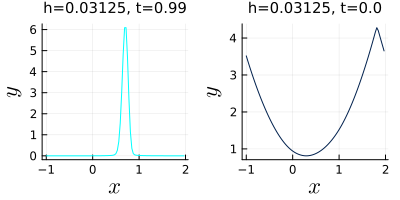

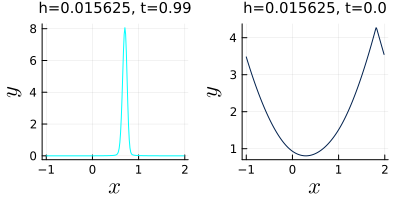

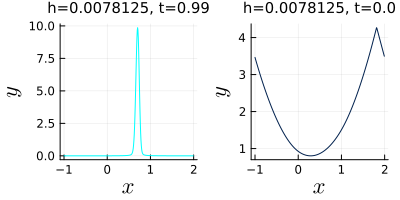

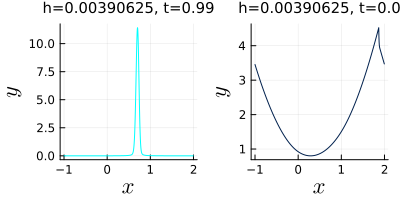

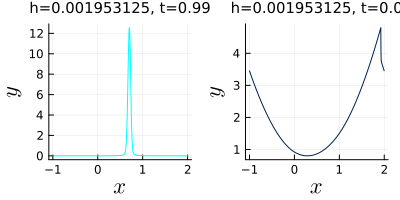

In [29]:
plot_final_time_results(h_list_used, 0.01, 1.0, 1.0, 7)

HI
[0.03125, 0.015625, 0.0078125, 0.00390625]
!!
size(U_list): (4,)
----


i: 1
Display:


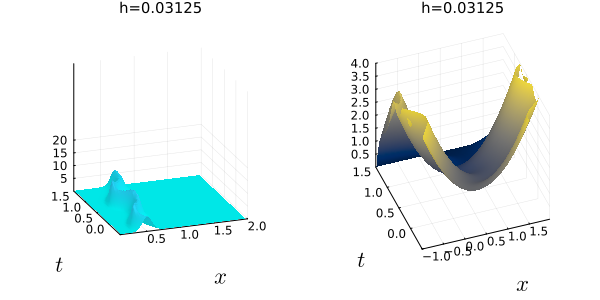

!!!!!!!!!
----
i: 2
Display:


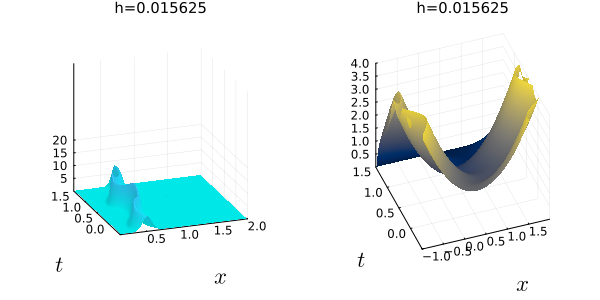

!!!!!!!!!
----
i: 3
Display:


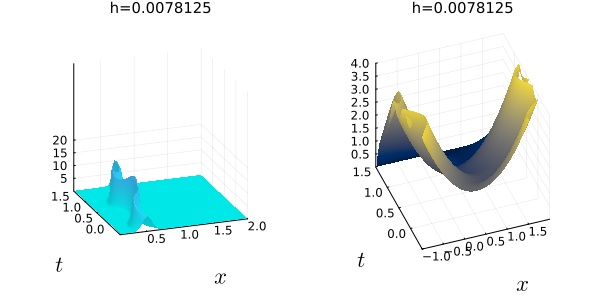

!!!!!!!!!
----
i: 4
Display:


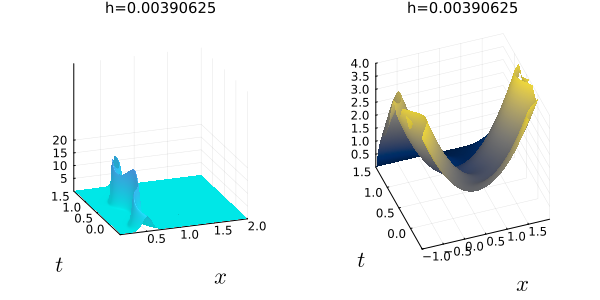

!!!!!!!!!


In [ ]:

#PLOT DATA, WHOLE DOMAIN


# plotusing Plots, LaTeXStrings;
using DelimitedFiles;
using Plots, LaTeXStrings;
println("HI")
println(h_list)
println("!!")
println("size(U_list): ", size(U_list))

for (i,h) in enumerate(h_list)
    println("----")
    println("i: ", i)
    
    #Select the same parameters as those used when generating the data:
    x_vec = -1:h:(2-h);
    N_h =length(x_vec);
    
    α = 1.0
    Δt = 0.01
    t_vec = 0:Δt:(2-Δt)
    N_T =length(t_vec)
    ν=0.09^2
    num_it_MFG=50
    num_it_HJB=20
    δ = 0.4
    R=30
    C_H = 0.5
    ############################
    plot_U_mat = U_list[i];
    plot_M_mat = M_list[i];

    zticks1 = 5:5:20
    p1 = plot(t_vec, x_vec, plot_M_mat, ylabel=L"x", xlabel=L"t",  st=:surface, labelfontsize=15, zlim=(0,50),
    color=cgrad(:cool, rev=false), size=(500, 500), xlim=(0,t_vec[end]), ylim=(0.1,2.0), legend=false, camera=(90- 20, 20), xflip=true, zticks=zticks1, title=L"m(x,t)")
    zticks2 = 0.5:0.5:4
    p2 = plot(t_vec, x_vec, plot_U_mat, xlabel=L"t", ylabel=L"x",   st=:surface, labelfontsize=15,
    color=:cividis, size=(500, 500), xlim=(0,t_vec[end]), zlim=(0, 4), legend=false, camera=(90- 20, 40), xflip=true, zticks=zticks2, title=L"u(x,t)") # ylim=(0, 1),

    p = plot(p1, p2, layout=2, size=(600, 300), title="h="*string(h), titlefontsize=10)
    println("Display:")
    display(p)
    # println("i: ", i)
    # if i==1
    #     break
    # end
    println("!!!!!!!!!")
end

FINAL TIME PLOTS
----
i: 1
time_index: 200
Display:
!!!!!!!!!
----
i: 2
time_index: 200
Display:
!!!!!!!!!
----
i: 3
time_index: 200
Display:
!!!!!!!!!
----
i: 4
time_index: 200
Display:
!!!!!!!!!
----
i: 5
time_index: 200
Display:
!!!!!!!!!
----
i: 6
time_index: 200
Display:
!!!!!!!!!


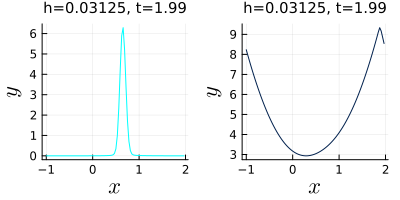

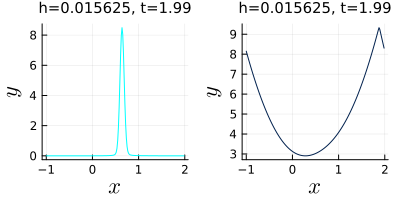

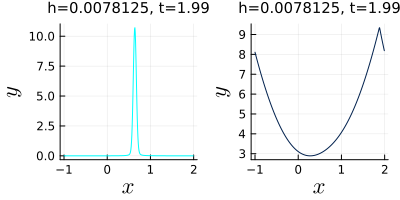

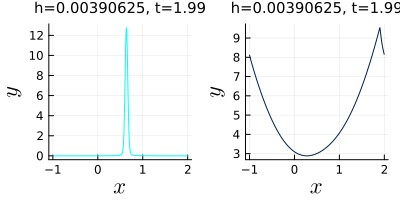

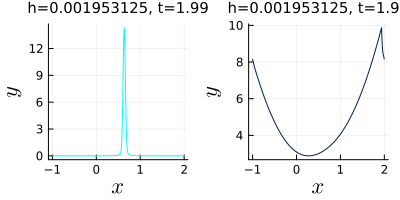

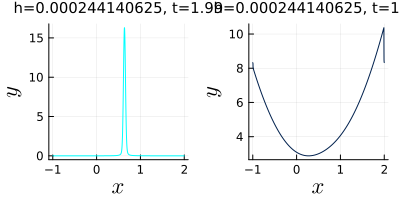

In [ ]:
#PLOT DATA AT FINAL TIME, WHOLE DOMAIN

println("FINAL TIME PLOTS")

for (i,h) in enumerate(h_list)
    println("----")
    println("i: ", i)

    #Select the same parameters as those used when generating the data
    x_vec = -1:h:(2-h);
    N_h =length(x_vec);
    
    α = 1.0 #1.5
    Δt = 0.01
    t_vec = 0:Δt:(2-Δt)
    N_T =length(t_vec)
    ν=0.09^2
    num_it_MFG=50
    num_it_HJB=20
    δ = 0.4
    R=30
    C_H = 0.5
    ##################################
    time_index = div(length(t_vec),1)
    println("time_index: ", time_index)

    plot_U_mat_final = U_list[i][:,1];
    plot_M_mat_final = M_list[i][:,time_index];

    p1 = plot(x_vec, plot_M_mat_final, xlabel=L"x", ylabel=L"y", labelfontsize=15,
    color=cgrad(:cool, rev=false), size=(500, 500), legend=false, title=L"m(x,1-Δt)") #, xlim=(0,1) )
    zticks2 = 0.5:0.5:4
    p2 = plot(x_vec, plot_U_mat_final, xlabel=L"x", ylabel=L"y", labelfontsize=15,
    color=:cividis, size=(500, 500), legend=false, title=L"u(x,0)") #,xlim=(0, 1),)

    p = plot(p1, p2, layout=2, size=(400, 200), title="h="*string(h)*", t="*string(t_vec[time_index]), titlefontsize=10)
    println("Display:")
    display(p)
    # println("i: ", i)
    # if i==1
    #     break
    # end
    println("!!!!!!!!!")
end

In [ ]:

#CONVERGENCE RATE CALCULATION FUNCTIONS 1

#assume vec, wrt_vec same sizes

function relative_max_error(vec, wrt_vec)
    max_difference = maximum(abs.(vec-wrt_vec))
    max_rel_error = max_difference/maximum(abs.(wrt_vec))
    max_index_diff = argmax(abs.(vec-wrt_vec))
    max_index_wrt_vec = argmax(abs.(wrt_vec))
    println("max_index_diff: ", max_index_diff, ". Total length: ", length(vec), ". x-pos: ", string((max_index_diff/length(vec))) )
    println("max_index_wrt_vec: ", max_index_wrt_vec, ". Total length: ", length(vec), ". x-pos: ", string((max_index_wrt_vec/length(vec))))
    return max_rel_error
end

function relative_l1_error(vec, wrt_vec)
    println("length(vec): ", length(vec))
    println("length(wrt_vec): ", length(wrt_vec))
    l1 = sum(abs.(vec-wrt_vec)) #*h
    l1_rel_error = l1/sum(abs.(wrt_vec)) # *1/h, which cancels with h from l1
    return l1_rel_error
end

relative_l1_error (generic function with 1 method)

In [ ]:
#CONVERGENCE RATE CALCULATION FUNCTIONS 2

function max_norm_convergence_rate(U_list, h_list, time_index=1)
    #time_index = 1 #terminal codition with index = 1, so at t=0
    println("time_index: " ,time_index)
    U_reference = U_list[end][:,time_index]

    U_rel_errors_list = []

    for (i,h) in enumerate(h_list[1:end-1])
        x_vec = -1:h:(2-h);      

        println("i: ", i)
        println("h: ", h)
        println("step: ", 2^(abs(log2(h_list[end]))-abs(log2(h))))
        restriction_step = Int(2^(abs(log2(h_list[end]))-abs(log2(h))))
        println("restriction_step: ", restriction_step)
        restricted_U_reference = U_reference[begin:restriction_step:end]
        println("length(restricted_U_reference): ", length(restricted_U_reference))

        U_current = U_list[i][:,time_index]
        println("length(U_current): ", length(U_current))

        cropped_restricted_U_reference =  restricted_U_reference[0 .<= x_vec .<1]
        cropped_U_current = U_current[0 .<= x_vec .<1]
        cropped_x_vec = x_vec[0 .<= x_vec .<1]

        println("length(x_vec): ", length(x_vec));
        println("length(cropped_x_vec): ", length(cropped_x_vec));
        println("collect(cropped_x_vec): ", collect(cropped_x_vec))
        println("length(cropped_restricted_U_reference): ", length(cropped_restricted_U_reference))
        println("length(cropped_U_current): ", length(cropped_U_current))

        U_rel_error = relative_max_error(cropped_U_current, cropped_restricted_U_reference)
        push!(U_rel_errors_list, U_rel_error)
    end

    println("U CONV RATES")
    U_conv_rates = []
    for i in 1:length(U_rel_errors_list[1:end-1])
        println("i: ", i)
        rate = log(U_rel_errors_list[i]/U_rel_errors_list[i+1])/(log(h_list[i]/h_list[i+1]))
        push!(U_conv_rates, rate)
    end

    return U_rel_errors_list, U_conv_rates
end

function L1_norm_convergence_rate(M_list, h_list)
    Δt = 0.01
    t_vec = 0:Δt:(2-Δt)
    N_T =length(t_vec)
    time_index = N_T
    M_reference = M_list[end][:,time_index]
    println("length(M_reference): ", length(M_reference))
    M_rel_errors_list = []

    for (i,h) in enumerate(h_list[1:end-1])
        x_vec = -1:h:(2-h);   

        println("i: ", i)
        println("h: ", h)
        println("step: ", 2^(abs(log2(h_list[end]))-abs(log2(h))))
        restriction_step = Int(2^(abs(log2(h_list[end]))-abs(log2(h))))
        println("restriction_step: ", restriction_step)
        restricted_M_reference = M_reference[begin:restriction_step:end]
        println("length(restricted_M_reference): ", length(restricted_M_reference))

        M_current = M_list[i][:,time_index]
        println("length(M_current): ", length(M_current))

        cropped_restricted_M_reference =  restricted_M_reference[0 .<= x_vec .<1]
        cropped_M_current = M_current[0 .<= x_vec .<1]
        cropped_x_vec = x_vec[0 .<= x_vec .<1]

        println("length(x_vec): ", length(x_vec));
        println("length(cropped_x_vec): ", length(cropped_x_vec));
        println("collect(cropped_x_vec): ", collect(cropped_x_vec))
        println("length(cropped_restricted_M_reference): ", length(cropped_restricted_M_reference))
        println("length(cropped_M_current): ", length(cropped_M_current))

        #M_rel_error = relative_l1_error(M_current, restricted_M_reference)
        M_rel_error = relative_l1_error(cropped_M_current, cropped_restricted_M_reference)
        push!(M_rel_errors_list, M_rel_error)
    end

    println("M CONV RATES")
    M_conv_rates = []
    for j in 1:length(M_rel_errors_list[1:end-1])
        println("j: ", j)
        rate = log(M_rel_errors_list[j]/M_rel_errors_list[j+1])/(log(h_list[j]/h_list[j+1]))
        push!(M_conv_rates, rate)
    end

    return M_rel_errors_list, M_conv_rates
end


L1_norm_convergence_rate (generic function with 1 method)

In [ ]:

#PRINT LISTS TO DOUBLE CHECK

println(h_list)
println(length(M_list))
println(length(U_list))

[0.03125, 0.015625, 0.0078125, 0.00390625, 0.001953125, 0.000244140625]
6
6


In [ ]:

#PRINT M CONVERGENCE


(M_e, M_conv) = L1_norm_convergence_rate(M_list, h_list)
println("")
(M_max_e, M_max_conv) = max_norm_convergence_rate(M_list, h_list, 200)

length(M_reference): 12288
i: 1
h: 0.03125
step: 128.0
restriction_step: 128
length(restricted_M_reference): 96
length(M_current): 96
length(x_vec): 96
length(cropped_x_vec): 32
collect(cropped_x_vec): [0.0, 0.03125, 0.0625, 0.09375, 0.125, 0.15625, 0.1875, 0.21875, 0.25, 0.28125, 0.3125, 0.34375, 0.375, 0.40625, 0.4375, 0.46875, 0.5, 0.53125, 0.5625, 0.59375, 0.625, 0.65625, 0.6875, 0.71875, 0.75, 0.78125, 0.8125, 0.84375, 0.875, 0.90625, 0.9375, 0.96875]
length(cropped_restricted_M_reference): 32
length(cropped_M_current): 32
length(vec): 32
length(wrt_vec): 32
i: 2
h: 0.015625
step: 64.0
restriction_step: 64
length(restricted_M_reference): 192
length(M_current): 192
length(x_vec): 192
length(cropped_x_vec): 64
collect(cropped_x_vec): [0.0, 0.015625, 0.03125, 0.046875, 0.0625, 0.078125, 0.09375, 0.109375, 0.125, 0.140625, 0.15625, 0.171875, 0.1875, 0.203125, 0.21875, 0.234375, 0.25, 0.265625, 0.28125, 0.296875, 0.3125, 0.328125, 0.34375, 0.359375, 0.375, 0.390625, 0.40625, 0.421875, 

(Any[0.5554290955971715, 0.39331157885476026, 0.2561092081700811, 0.14994771820059785, 0.07898590477753609], Any[0.49793009429723123, 0.6189135343387148, 0.7722995561853133, 0.9247924394388616])

In [ ]:

#PRINT U CONVERGENCE

println("U:")
(U_e, U_conv) = max_norm_convergence_rate(U_list, h_list)

U:
time_index: 1
i: 1
h: 0.03125
step: 128.0
restriction_step: 128
length(restricted_U_reference): 96
length(U_current): 96
length(x_vec): 96
length(cropped_x_vec): 32
collect(cropped_x_vec): [0.0, 0.03125, 0.0625, 0.09375, 0.125, 0.15625, 0.1875, 0.21875, 0.25, 0.28125, 0.3125, 0.34375, 0.375, 0.40625, 0.4375, 0.46875, 0.5, 0.53125, 0.5625, 0.59375, 0.625, 0.65625, 0.6875, 0.71875, 0.75, 0.78125, 0.8125, 0.84375, 0.875, 0.90625, 0.9375, 0.96875]
length(cropped_restricted_U_reference): 32
length(cropped_U_current): 32
max_index_diff: 1. Total length: 32. x-pos: 0.03125
max_index_wrt_vec: 32. Total length: 32. x-pos: 1.0
i: 2
h: 0.015625
step: 64.0
restriction_step: 64
length(restricted_U_reference): 192
length(U_current): 192
length(x_vec): 192
length(cropped_x_vec): 64
collect(cropped_x_vec): [0.0, 0.015625, 0.03125, 0.046875, 0.0625, 0.078125, 0.09375, 0.109375, 0.125, 0.140625, 0.15625, 0.171875, 0.1875, 0.203125, 0.21875, 0.234375, 0.25, 0.265625, 0.28125, 0.296875, 0.3125, 0.32812

(Any[0.02029184968029124, 0.009612710217223071, 0.004532849346420413, 0.0020953759510785753, 0.000957725780463384], Any[1.0778852299417332, 1.0845250305741485, 1.1132090980571772, 1.1295245721185445])

In [ ]:
#PRINT M AND U CONVERGENCE

println("M: ")
println(M_e)
println(M_conv)

println("M_max: ")
println(M_max_e)
println(M_max_conv)

println("U: ")
println(U_e)
println(U_conv)

M: 
Any[0.8371434014618365, 0.5890567083683197, 0.37614443129799974, 0.219614738869499, 0.11578391557465077]
Any[0.5070682468355016, 0.6471197968273381, 0.7763118515682635, 0.9235400288082044]
M_max: 
Any[0.5961775590011134, 0.46704652518198203, 0.34403702696400307, 0.2166614190970575, 0.12194731067456899]
Any[0.3521757989733454, 0.4410024289685991, 0.667121567679874, 0.8291843330910339]
U: 
Any[0.02029184968029124, 0.009612710217223071, 0.004532849346420413, 0.0020953759510785753, 0.000957725780463384]
Any[1.0778852299417332, 1.0845250305741485, 1.1132090980571772, 1.1295245721185445]


In [ ]:
#PRINT U AND M CONVERGENCE FOR LATEX


using Printf
# Print LaTeX table header
println("\\begin{tabular}{|c|c|c|c|c|c|c|}")
println("\\hline")
println("\$h\$ & U rel. \$L^{\\infty}\$ error  & U rate & M rel. \$L^{1}\$ error & M rate (\$L^1\$) & M rel. \$L^{\\infty}\$ error & M rate (\$L^{\\infty}\$) \\\\")
println("\\hline")

# Print the rows of the table
for i in 1:length(h_list)-1
    U_re_s_num = @sprintf "%.2e" U_e[i]    
    M_re_s_num = @sprintf "%.3f" M_e[i]
    M_max_re_s_num = @sprintf "%.3f" M_max_e[i]

    if i==1
        U_ra_s_num = "--"
        M_ra_s_num = "--"
        M_max_ra_s_num = "--"
        println("\$2^{",string(Int(log2(h_list[i])),"}\$", " & ", "\$",U_re_s_num,"\$"," & ", "--", " & ", "\$",M_re_s_num,"\$", " & ","--"," & ","\$", M_max_re_s_num,"\$", " & ","--", " \\\\"))
        println("\\hline")
    else
        U_ra_s_num = @sprintf "%.2f" U_conv[i-1]
        M_ra_s_num = @sprintf "%.2f" M_conv[i-1]
        M_max_ra_s_num = @sprintf "%.2f" M_max_conv[i-1]
    
        println("\$2^{",string(Int(log2(h_list[i])),"}\$", " & ", "\$",U_re_s_num,"\$"," & ", "\$",U_ra_s_num,"\$", " & ", "\$",M_re_s_num,"\$", " & ","\$", M_ra_s_num,"\$"," & ","\$", M_max_re_s_num,"\$", " & ","\$", M_max_ra_s_num,"\$", " \\\\"))
        println("\\hline")
    end
end

# Print LaTeX table footer
println("\\end{tabular}")

\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
$h$ & U rel. $L^{\infty}$ error  & U rate & M rel. $L^{1}$ error & M rate ($L^1$) & M rel. $L^{\infty}$ error & M rate ($L^{\infty}$) \\
\hline


UndefVarError: UndefVarError: `h_list` not defined